# Exploratory Analysis

---

This notebook outlines the process for exploring the Zillow property data used in this project.

---

## Importing the Required Modules

Below we import all the modules needed to run this notebook. (Note on other user modules needed)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from univariate_analysis import get_hist, get_box

from env import username, password, hostname

## Acquire Data

Here we define all our acquisition and preparation functions created in the acquire and prepare notebook.

In [2]:
def get_db_url(database_name, username = username, password = password, hostname = hostname):
    return f'mysql+pymysql://{username}:{password}@{hostname}/{database_name}'

def get_zillow_sql():
    return """
        SELECT
            properties_2017.parcelid,
            bedroomcnt,
            bathroomcnt,
            calculatedfinishedsquarefeet,
            taxvaluedollarcnt,
            yearbuilt,
            fips,
            numberofstories,
            basementsqft,
            fireplacecnt,
            heatingorsystemdesc,
            airconditioningdesc,
            roomcnt,
            garagetotalsqft,
            hashottuborspa,
            poolcnt,
            poolsizesum,
            yardbuildingsqft17,
            buildingqualitytypeid,
            finishedfloor1squarefeet,
            finishedsquarefeet15,
            lotsizesquarefeet 
        FROM properties_2017
        JOIN propertylandusetype
            ON propertylandusetype.propertylandusetypeid = properties_2017.propertylandusetypeid
            AND (propertylandusetype.propertylandusedesc IN ('Single Family Residential', 'Inferred Single Family Residential'))
        LEFT JOIN heatingorsystemtype USING (heatingorsystemtypeid)
        LEFT JOIN airconditioningtype USING (airconditioningtypeid)
        JOIN predictions_2017 ON properties_2017.parcelid = predictions_2017.parcelid
        AND predictions_2017.transactiondate LIKE '2017%%';
        """

def get_zillow_data(use_cache = True):
    # If the file is cached, read from the .csv file
    if os.path.exists('zillow.csv') and use_cache:
        print('Using cache')
        return pd.read_csv('zillow.csv')
    
    # Otherwise read from the mysql database
    else:
        print('Reading from database')
        df = pd.read_sql(get_zillow_sql(), get_db_url('zillow'))
        df.to_csv('zillow.csv', index = False)
        return df
    
def prepare_zillow_data(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    '''
        Returns a prepared zillow dataset with all missing values handled.
        
        Parameters
        ----------
        df: DataFrame
            A pandas dataframe containing the unprepared zillow dataset.
        
        Returns
        -------
        DataFrame: A pandas dataframe containing the prepared zillow dataset.
    '''
    
    missing_target = df.taxvaluedollarcnt.isnull()
    df = df[~missing_target]
    
    avg_square_feet = df.calculatedfinishedsquarefeet.mean()
    df.calculatedfinishedsquarefeet.fillna(avg_square_feet, inplace = True)
    
    df.yearbuilt.fillna(df.yearbuilt.mode()[0], inplace = True)
    df.fireplacecnt.fillna(0, inplace = True)
    df.hashottuborspa.fillna(0, inplace = True)
    df.poolcnt.fillna(0, inplace = True)
    
    median_quality = df.buildingqualitytypeid.median()
    df.buildingqualitytypeid.fillna(median_quality, inplace = True)
    
    median_lotsize = df.lotsizesquarefeet.median()
    df.lotsizesquarefeet.fillna(median_lotsize, inplace = True)
    
    df = df.drop(columns = 'parcelid')
    df = df.drop(columns = 'numberofstories')
    df = df.drop(columns = 'basementsqft')
    df = df.drop(columns = 'heatingorsystemdesc')
    df = df.drop(columns = 'airconditioningdesc')
    df = df.drop(columns = 'garagetotalsqft')
    df = df.drop(columns = 'poolsizesum')
    df = df.drop(columns = 'yardbuildingsqft17')
    df = df.drop(columns = 'roomcnt')
    df = df.drop(columns = 'finishedfloor1squarefeet')
    df = df.drop(columns = 'finishedsquarefeet15')
    
    df.bedroomcnt = df.bedroomcnt.astype('int')
    df.fireplacecnt = df.fireplacecnt.astype('int')
    df.hashottuborspa = df.hashottuborspa.astype('int')
    df.poolcnt = df.poolcnt.astype('int')
    
    df.fips = df.fips.astype('int')
    df.fips = df.fips.astype('object')
    df = pd.get_dummies(df, columns = ['fips'])
    
    df['property_age'] = 2017 - df.yearbuilt
    df = df.drop(columns = 'yearbuilt')

    # Rename the columns for readability
    df = df.rename(columns = {
        'bedroomcnt' : 'bedroom_count',
        'bathroomcnt' : 'bathroom_count',
        'calculatedfinishedsquarefeet' : 'square_feet',
        'taxvaluedollarcnt' : 'property_tax_assessed_values',
        'fireplacecnt' : 'fireplace_count',
        'hashottuborspa' : 'has_hot_tub',
        'poolcnt' : 'has_pool',
        'buildingqualitytypeid' : 'building_quality',
        'lotsizesquarefeet' : 'lot_size',
        'fips_6037' : 'fed_code_6037',
        'fips_6059' : 'fed_code_6059',
        'fips_6111' : 'fed_code_6111'
    })
    
    return df

In [3]:
properties = prepare_zillow_data(get_zillow_data())
properties.info()

Using cache
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52440 entries, 0 to 52440
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroom_count                 52440 non-null  int64  
 1   bathroom_count                52440 non-null  float64
 2   square_feet                   52440 non-null  float64
 3   property_tax_assessed_values  52440 non-null  float64
 4   fireplace_count               52440 non-null  int64  
 5   has_hot_tub                   52440 non-null  int64  
 6   has_pool                      52440 non-null  int64  
 7   building_quality              52440 non-null  float64
 8   lot_size                      52440 non-null  float64
 9   fed_code_6037                 52440 non-null  uint8  
 10  fed_code_6059                 52440 non-null  uint8  
 11  fed_code_6111                 52440 non-null  uint8  
 12  property_age                  52440 non-null  fl

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


## Split Data

Now before we proceed we must split the data. Note that it is not necessary to split the data until we get to bi-variate analysis, but we'll do it now just to be safe.

In [4]:
def split_data(df, random_seed = 24, stratify = None):
    test_split = 0.2
    train_validate_split = 0.3

    train_validate, test = train_test_split(
        df,
        test_size = test_split,
        random_state = random_seed,
        stratify = stratify if not stratify else df[stratify]
    )
    train, validate = train_test_split(
        train_validate,
        test_size = train_validate_split,
        random_state = random_seed,
        stratify = stratify if not stratify else train_validate[stratify]
    )
    return train, validate, test

In [5]:
train, validate, test = split_data(properties)
train.shape, validate.shape, test.shape

((29366, 13), (12586, 13), (10488, 13))

## Univariate Analysis

We'll start by analyzing the distributions of values in each of our features. This will allow us to identify outliers and possibly make some initial assumptions about which features may be worth looking more closely at.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29366 entries, 48806 to 1939
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroom_count                 29366 non-null  int64  
 1   bathroom_count                29366 non-null  float64
 2   square_feet                   29366 non-null  float64
 3   property_tax_assessed_values  29366 non-null  float64
 4   fireplace_count               29366 non-null  int64  
 5   has_hot_tub                   29366 non-null  int64  
 6   has_pool                      29366 non-null  int64  
 7   building_quality              29366 non-null  float64
 8   lot_size                      29366 non-null  float64
 9   fed_code_6037                 29366 non-null  uint8  
 10  fed_code_6059                 29366 non-null  uint8  
 11  fed_code_6111                 29366 non-null  uint8  
 12  property_age                  29366 non-null  float64
dty

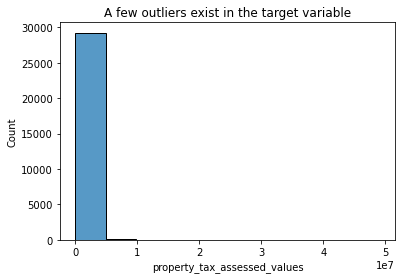

In [7]:
# In the next two plots we'll see how our target variable is distributed.
sns.histplot(train.property_tax_assessed_values, bins = 10)
plt.title('A few outliers exist in the target variable');

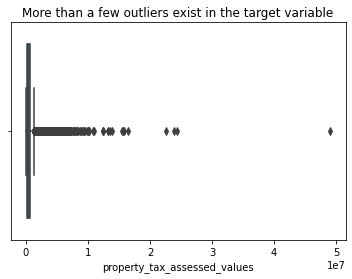

In [8]:
sns.boxplot(data = train, x = 'property_tax_assessed_values')
plt.title('More than a few outliers exist in the target variable');

Let's see how the target is distributed without the outliers.

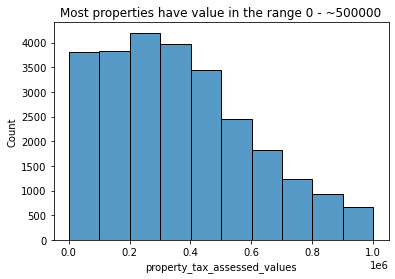

In [9]:
mask = train.property_tax_assessed_values < 1_000_000
sns.histplot(train[mask].property_tax_assessed_values, bins = 10)
plt.title('Most properties have value in the range 0 - ~500000');

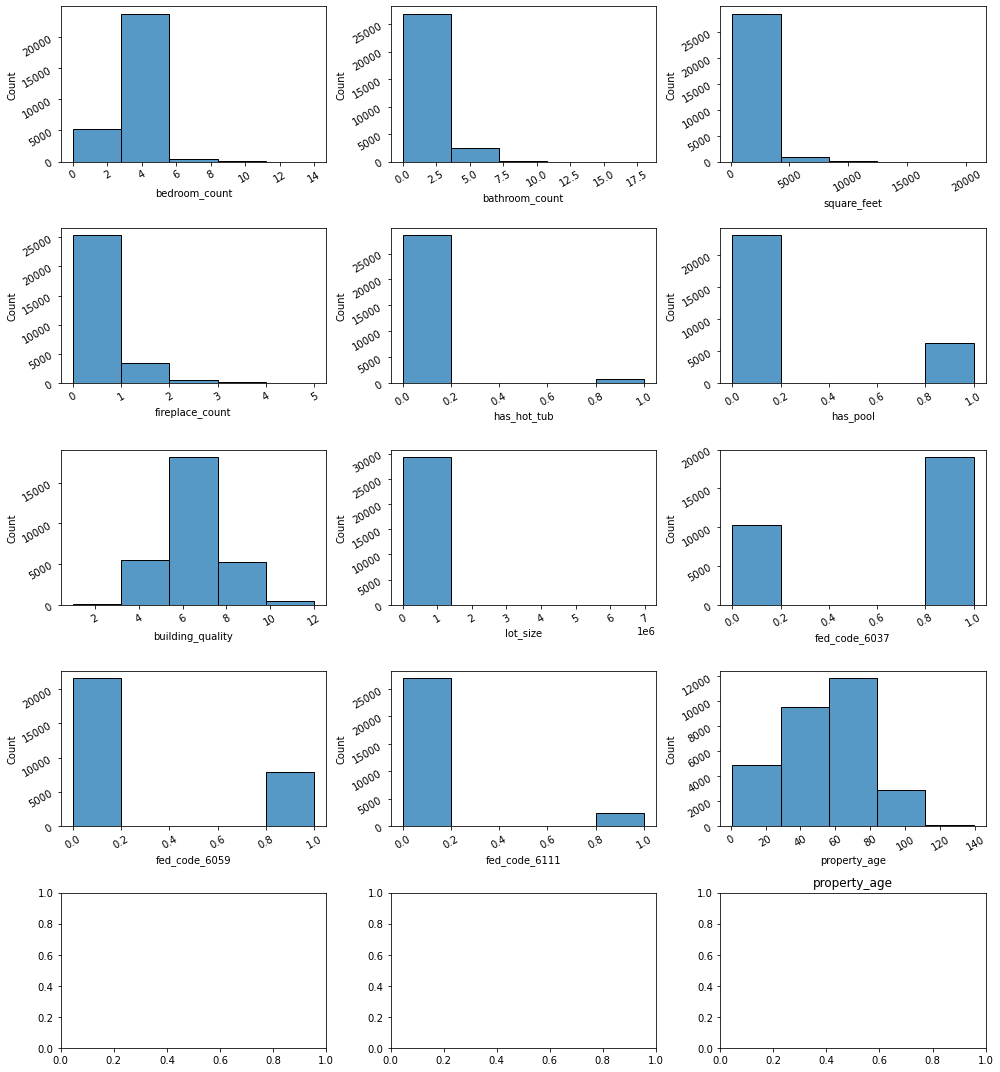

In [10]:
# Let's see histograms of all our features
get_hist(train, train.drop(columns = 'property_tax_assessed_values').columns)

Here is what insights we can gather from the histograms.

- bedroom_count and year_built are all normally distributed.
- most properties at fed code 6037.
- no basement, fireplace, hot tub, pool are common.
- bedroom_count, bathroom_count, square_feet, and lot_size have outliers.

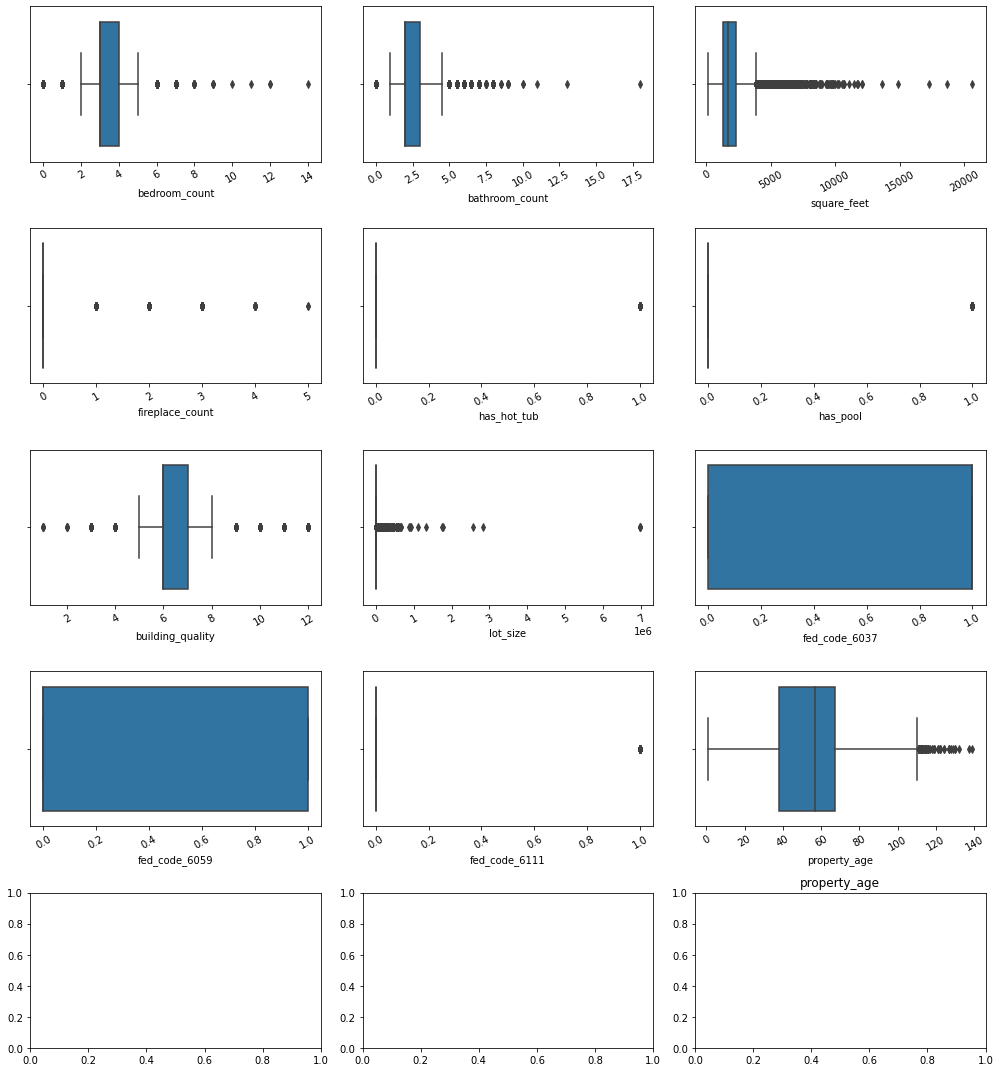

In [11]:
# Let's see boxplots for all our numeric features
get_box(train, train.drop(columns = 'property_tax_assessed_values').columns)

There are some outliers in the data but not enough to be concerning. We'll ensure these are removed before beginning modeling.

## Bivariate Analysis

Now let's see how our features interact with the target variable so we can determine which features are the most relevant for our problem.

### Correlation Heat Map

Let's see how each of our features correlate with the target variable.

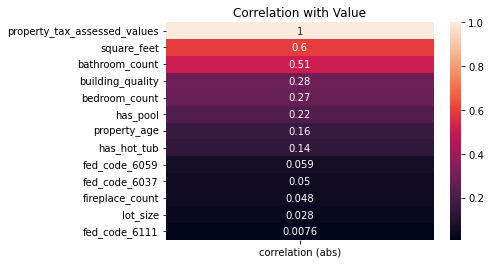

In [12]:
corr = pd.DataFrame(train.corr().abs().property_tax_assessed_values).sort_values(by='property_tax_assessed_values', ascending=False)
corr.columns = ['correlation (abs)']
sns.heatmap(corr, annot=True)
plt.title('Correlation with Value');

### Bedroom Count

Is there a relationship between the number of bedrooms in a home and the property value?

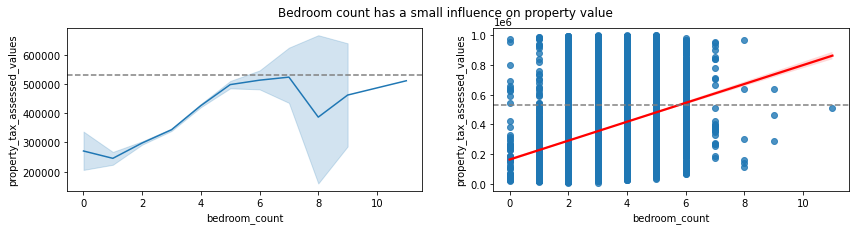

In [13]:
# Bedroom count vs. property value

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 3))
mean = train.property_tax_assessed_values.mean()

fig.suptitle('Bedroom count has a small influence on property value')

sns.lineplot(data = train[mask], x = 'bedroom_count', y = 'property_tax_assessed_values', ax = ax[0])
ax[0].axhline(mean, ls='--', color='grey')

sns.regplot(data = train[mask], x = 'bedroom_count', y = 'property_tax_assessed_values', ax = ax[1], line_kws = {'color' : 'red'})
ax[1].axhline(mean, ls='--', color='grey');

### Bathroom Count

Is there a relationship between the number of bathrooms in a home and the property value?

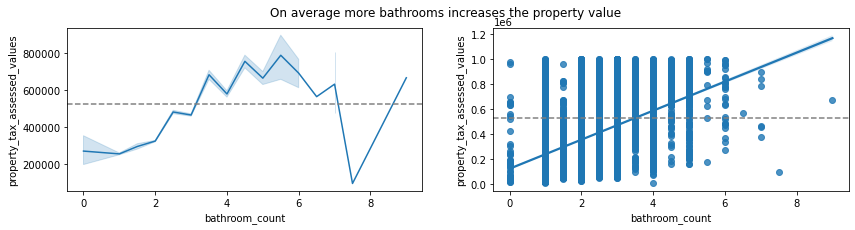

In [14]:
# Bathroom count vs. property value

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 3))
mean = train.property_tax_assessed_values.mean()

fig.suptitle('On average more bathrooms increases the property value')

sns.lineplot(data = train[mask], x = 'bathroom_count', y = 'property_tax_assessed_values', ax = ax[0])
ax[0].axhline(mean, ls='--', color='grey')

sns.regplot(data = train[mask], x = 'bathroom_count', y = 'property_tax_assessed_values', ax = ax[1])
ax[1].axhline(mean, ls='--', color='grey');

### Square Footage

Is there a relationship between the square footage of a property and its value?

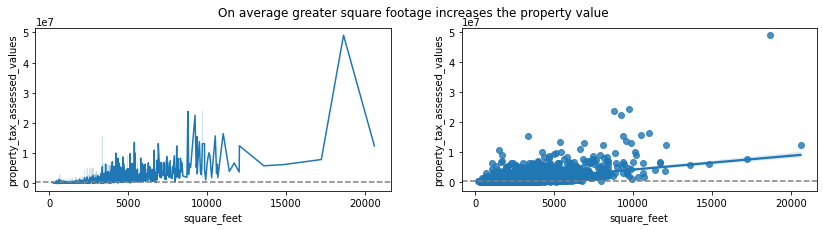

In [15]:
# Square footage vs. property value

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 3))
mean = train.property_tax_assessed_values.mean()

fig.suptitle('On average greater square footage increases the property value')

sns.lineplot(data = train, x = 'square_feet', y = 'property_tax_assessed_values', ax = ax[0])
ax[0].axhline(mean, ls='--', color='grey')

sns.regplot(data = train, x = 'square_feet', y = 'property_tax_assessed_values', ax = ax[1])
ax[1].axhline(mean, ls='--', color='grey');

### Fed Code

Does the location of a property influence its value?

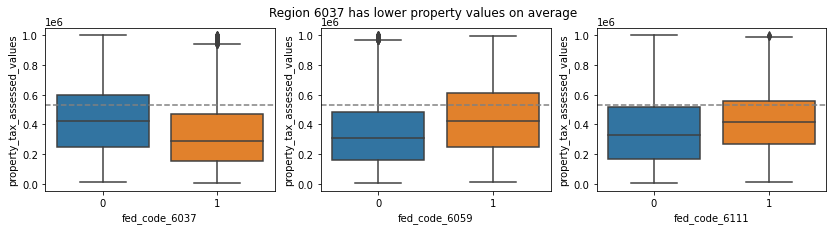

In [16]:
# location vs. property value
# We apply the mask (property value less than 1,000,000) in order to see the results more clearly.

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (14, 3))
fig.suptitle('Region 6037 has lower property values on average')

mean = train.property_tax_assessed_values.mean()

sns.boxplot(data = train[mask], x = 'fed_code_6037', y = 'property_tax_assessed_values', ax = ax[0])
ax[0].axhline(mean, ls='--', color='grey')

sns.boxplot(data = train[mask], x = 'fed_code_6059', y = 'property_tax_assessed_values', ax = ax[1])
ax[1].axhline(mean, ls='--', color='grey')

sns.boxplot(data = train[mask], x = 'fed_code_6111', y = 'property_tax_assessed_values', ax = ax[2])
ax[2].axhline(mean, ls='--', color='grey');

### Property Age

Is there a relationship between a property's age and its value?

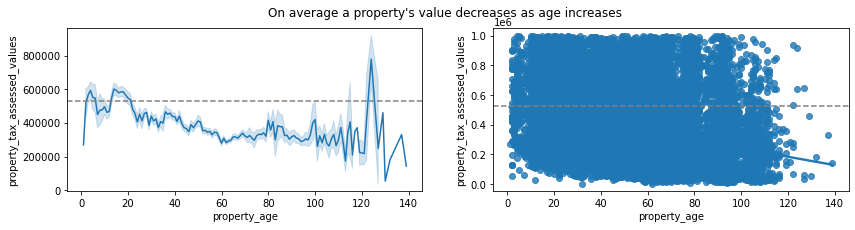

In [17]:
# year built vs. property value

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 3))
mean = train.property_tax_assessed_values.mean()

fig.suptitle("On average a property's value decreases as age increases")

sns.lineplot(data = train[mask], x = 'property_age', y = 'property_tax_assessed_values', ax = ax[0])
ax[0].axhline(mean, ls='--', color='grey')

sns.regplot(data = train[mask], x = 'property_age', y = 'property_tax_assessed_values', ax = ax[1])
ax[1].axhline(mean, ls='--', color='grey');

### Has Pool

Does a swimming pool increase a property's value?

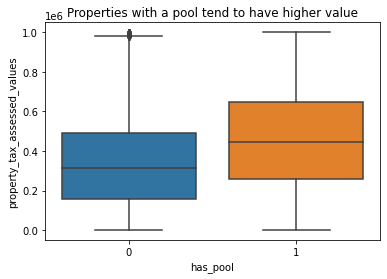

In [18]:
# Pool vs. property value

sns.boxplot(data = train[mask], x = 'has_pool', y = 'property_tax_assessed_values')
plt.title("Properties with a pool tend to have higher value");

### Has Hot Tub

Does a hot tub increase a property's value?

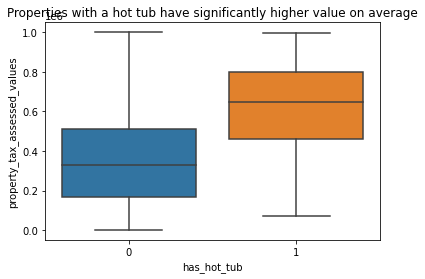

In [19]:
# hot tub vs. property value

sns.boxplot(data = train[mask], x = 'has_hot_tub', y = 'property_tax_assessed_values')
plt.title('Properties with a hot tub have significantly higher value on average');

### Fireplace

Does a fireplace increase a property's value?

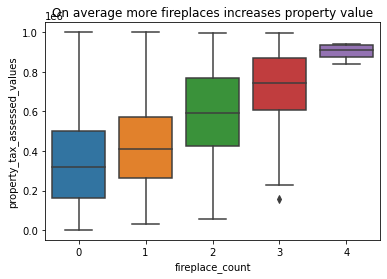

In [20]:
# fireplace vs. property value

sns.boxplot(data = train[mask], x = 'fireplace_count', y = 'property_tax_assessed_values')
plt.title('On average more fireplaces increases property value');

### Building Quality

Does the quality of a building relate to its value?

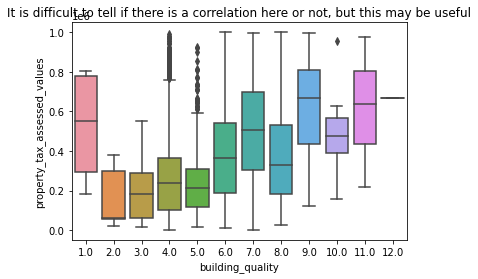

In [21]:
# building quality vs. property value

sns.boxplot(data = train[mask], x = 'building_quality', y = 'property_tax_assessed_values')
plt.title('It is difficult to tell if there is a correlation here or not, but this may be useful');

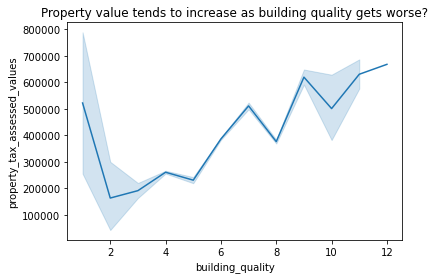

In [22]:
sns.lineplot(data = train[mask], x = 'building_quality', y = 'property_tax_assessed_values')
plt.title('Property value tends to increase as building quality gets worse?');

### Lot Size

Does lot size relate to property value?

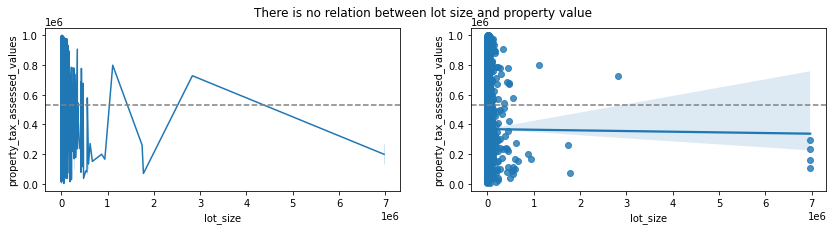

In [23]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 3))
mean = train.property_tax_assessed_values.mean()

fig.suptitle("There is no relation between lot size and property value")

sns.lineplot(data = train[mask], x = 'lot_size', y = 'property_tax_assessed_values', ax = ax[0])
ax[0].axhline(mean, ls='--', color='grey')

sns.regplot(data = train[mask], x = 'lot_size', y = 'property_tax_assessed_values', ax = ax[1])
ax[1].axhline(mean, ls='--', color='grey');

The features that appear to have the most influence on property value are the following:

- bedroom count
- bathroom count
- square feet
- location
- property age
- has pool
- has hot tub
- fireplace count

---

## Multivariate Analysis

Now that we have some idea of which features have the most influence on our target variable let's answer some of these questions.

- Is there a relationship between location and property age?
- Does the number of bedrooms and bathrooms matter?
- Does square feet relate to property age?
- Does having a pool, hot tub, or fireplace influence property value?

### Location and Property Age

Let's see if there is a relationship between location and property age.

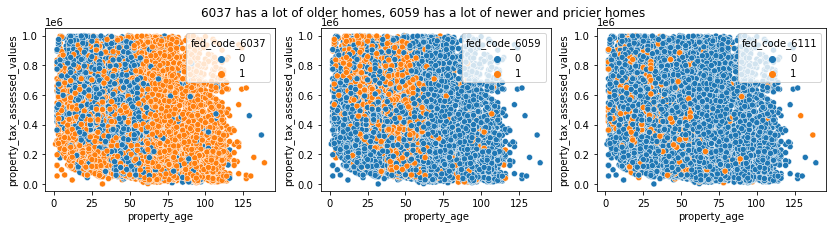

In [24]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (14, 3))
fig.suptitle('6037 has a lot of older homes, 6059 has a lot of newer and pricier homes')

sns.scatterplot(
    data = train[mask],
    x = 'property_age',
    y = 'property_tax_assessed_values',
    hue = 'fed_code_6037',
    ax = ax[0]
)
sns.scatterplot(
    data = train[mask],
    x = 'property_age',
    y = 'property_tax_assessed_values',
    hue = 'fed_code_6059',
    ax = ax[1]
)
sns.scatterplot(
    data = train[mask],
    x = 'property_age',
    y = 'property_tax_assessed_values',
    hue = 'fed_code_6111',
    ax = ax[2]
);

### Bedroom and Bathrooms

Let's see if the total bedrooms and bathrooms can be helpful.

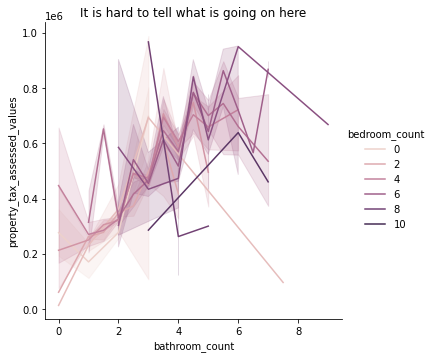

In [25]:
sns.relplot(
    data = train[mask],
    x = "bathroom_count",
    y = "property_tax_assessed_values",
    hue = "bedroom_count",
    kind = "line"
)
plt.title('It is hard to tell what is going on here');

### Square Feet and Property Age

Let's see if there is a relationship between square footage and property age.

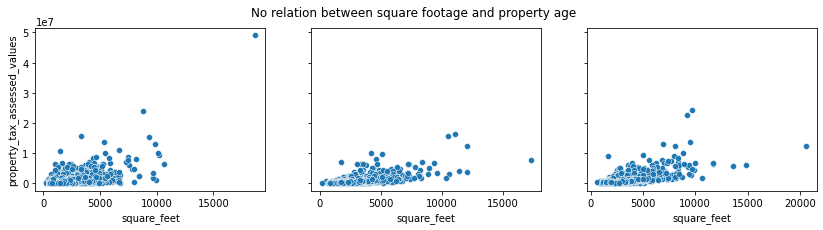

In [26]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (14, 3), sharey = True)
fig.suptitle('No relation between square footage and property age')

old_age = train.property_age >= 50
mid_age = (train.property_age < 50) & (train.property_age >= 25)
young_age = train.property_age < 25

sns.scatterplot(
    data = train[old_age],
    x = 'square_feet',
    y = 'property_tax_assessed_values',
    ax = ax[0]
)

sns.scatterplot(
    data = train[mid_age],
    x = 'square_feet',
    y = 'property_tax_assessed_values',
    ax = ax[1]
)

sns.scatterplot(
    data = train[young_age],
    x = 'square_feet',
    y = 'property_tax_assessed_values',
    ax = ax[2]
);

### Pool, Hot Tub, and Fireplace

Does the total of pool, hot tub and fireplace relate to a property's value?

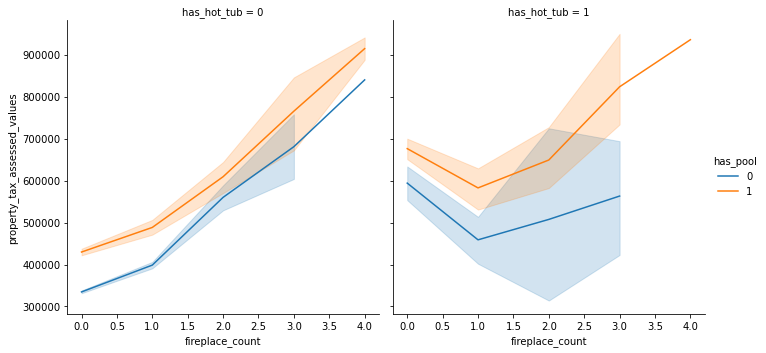

In [27]:
sns.relplot(
    data = train[mask],
    x = "fireplace_count",
    y = "property_tax_assessed_values",
    hue = "has_pool",
    col = 'has_hot_tub',
    kind = 'line'
);

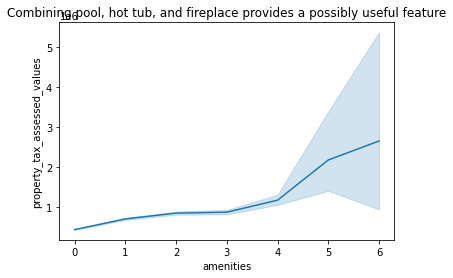

In [28]:
train['amenities'] = train.has_hot_tub + train.has_pool + train.fireplace_count

sns.lineplot(
    data = train,
    x = "amenities",
    y = "property_tax_assessed_values"
)
plt.title('Combining pool, hot tub, and fireplace provides a possibly useful feature');

## Takeaways

From the analysis we can determine that the features that are most relevant for predicting property value are:

- bedroom count
- bathroom count
- square feet
- location (particularly code 6037)
- property age
- total amenities
- possibly, building quality

We will now perform statistical tests to determine if there are relationships between these features and the target variable.

## Hypothesis Testing

In [29]:
from stats_util import *

$H_0$: The square footage of a property does not correlate with the value of the property.
<br>
$H_a$: The square footage of a property correlates with the value of the property.

In [30]:
correlation_test(train.square_feet, train.property_tax_assessed_values)

r = 0.5974
p = 0.0000

Reject H0


$H_0$: The age of a property does not correlate with the value of the property.
<br>
$H_a$: The age of a property correlates with the value of the property.

In [31]:
correlation_test(train.property_age, train.property_tax_assessed_values)

r = -0.1586
p = 0.0000

Reject H0


$H_0$: The number of bedrooms a property has does not correlate with the value of the property.
<br>
$H_a$: The number of bedrooms a property has correlates with the value of the property.

In [32]:
correlation_test(train.bedroom_count, train.property_tax_assessed_values)

r = 0.2749
p = 0.0000

Reject H0


$H_0$: The number of bathrooms a property has does not correlate with the value of the property.
<br>
$H_a$: The number of bathrooms a property has correlates with the value of the property.

In [33]:
correlation_test(train.bathroom_count, train.property_tax_assessed_values)

r = 0.5100
p = 0.0000

Reject H0


$H_0$: The total number of amenities a property has does not correlate with the value of the property.
<br>
$H_a$: The total number of amenities a property has correlates with the value of the property.

In [34]:
correlation_test(train.amenities, train.property_tax_assessed_values)

r = 0.1931
p = 0.0000

Reject H0


$H_0$: The quality of a building does not correlate with the value of the property.
<br>
$H_a$: The quality of a building correlates with the value of the property.

In [35]:
correlation_test(train.building_quality, train.property_tax_assessed_values)

r = 0.2848
p = 0.0000

Reject H0


$H_0$: There is no difference in property value between homes in Los Angeles County and homes in other counties.
<br>
$H_a$: There is a difference in property value between homes in Los Angeles County and homes in other counties.

In [36]:
los_angeles_county = train.fed_code_6037 == 1
other_county = train.fed_code_6037 == 0
two_sample_ttest(train[los_angeles_county].property_tax_assessed_values, train[other_county].property_tax_assessed_values)

Samples contain more than 30 observations: True
Samples have equal variances: True
Using parametric test...

Reject H0


## Conclusions

We'll move forward with square_feet, bedroom_count, bathroom_count, property_age, amenities, and building quality. Additionally, there does seem to be differences in value depending on the location. Perhaps we account for this by building different models for each county.